# Culvert Performance Curve Validation

This notebook shows a method to validate culverts in swmm/xpswmm/icm models using the HY8 results.

# Performance Curve

[HY-8 Culvert Hydraulic Analysis Program](https://www.fhwa.dot.gov/engineering/hydraulics/software/hy8/) can calculate culvert performance curves uisng the [FWHA HDS5 ](https://www.fhwa.dot.gov/engineering/hydraulics/pubs/12026/hif12026.pdf) methods. An example is shown below.



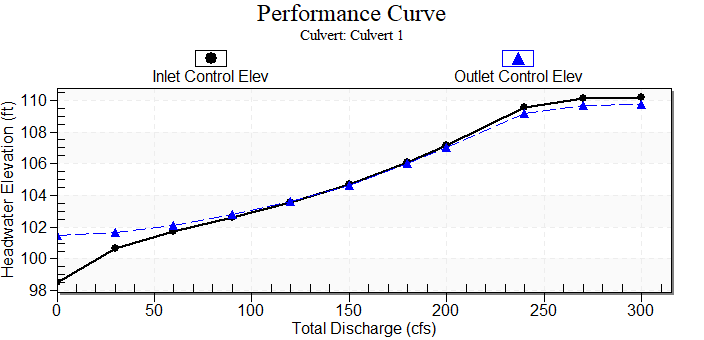

I write a few scripts in this notebook to automate the process of comparing the modeling results to the HY8 results.

Major steps are,

- Setup the HY8 culvert model, and create the discharge vs inlet/outlet table
- Setup the swmm5 model, and run the model
- Setup the XPSWMM model, and create results table.

# Setup HY8 Culvert Model

Setting up a culvert model in HY8 is farily straight forward.

The model is saved to : **./data/inverted/hds5_example.hy8**


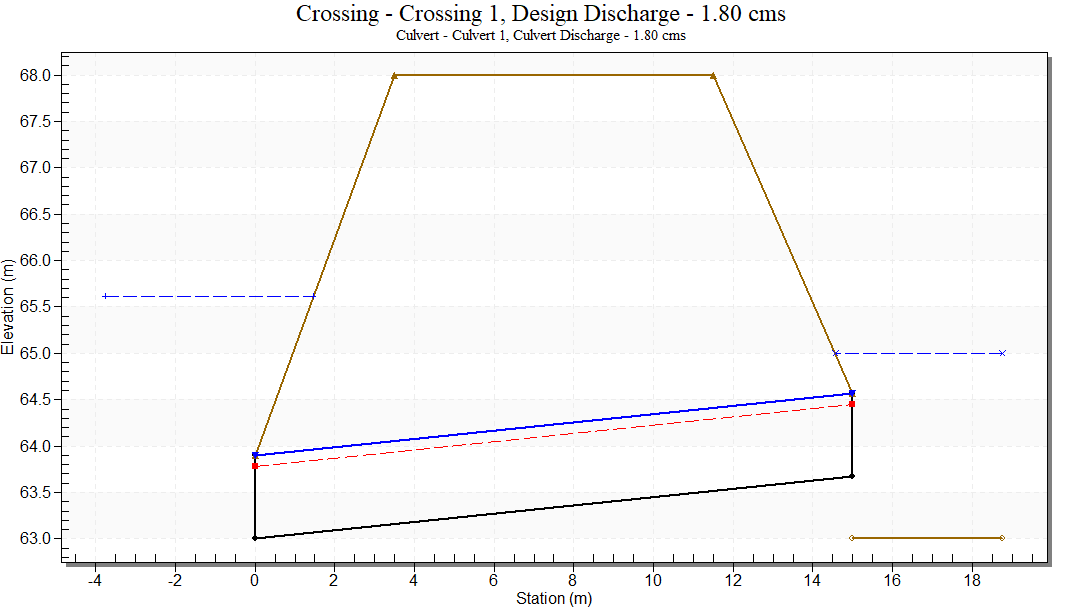

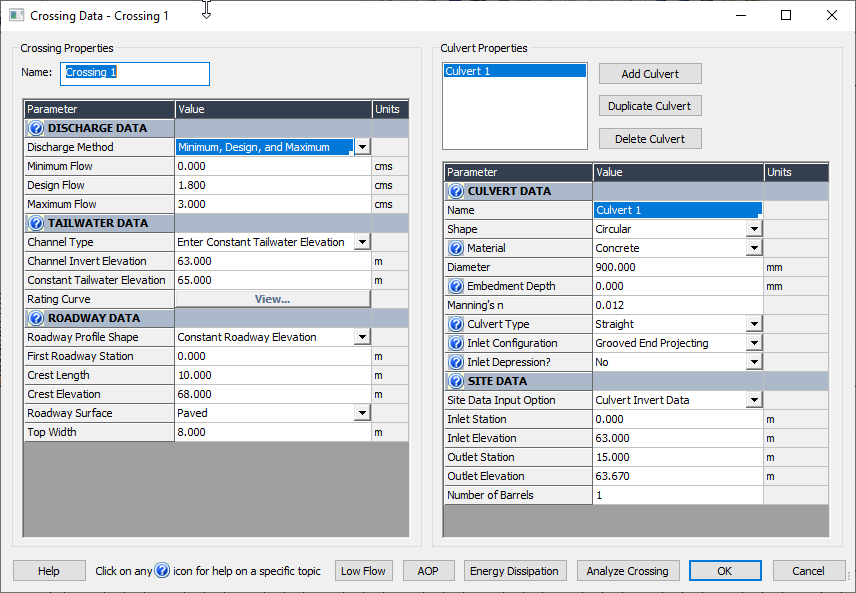

# Create Performance Curve Table

Copy and paste the discharge, inlet, outlet control depths columns into the csv file: **data\inverted\inverted_performance_curve2.csv**

# Setup SWMM5 Model

A swmm5 model is created: 

Model: **./data/inverted/inverted.inp**

- For the culvert, don't set any losses, entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 0 - 300 cfs in 6 hours.
- The depth vs total inflow in node 54RCP_2 should give the performance curve
- added 3.5ft tail water at outlet
- Had to use a hotstart file to get the starting level correct

# Setup an XPSWMM Model

Import the xpx file into XPSWMM and run the model

Model:**./data/inverted/inverted.xpx**

# Create xpswmm results table

Export the node stage and link flow to a csv file.

- graph the node, export the stage time series
- graph the link, export the flow time series

The results are saved in : **./data/inverted/xpsmm.csv**




In [1]:
from swmm.output import output as smo
import pandas as pd
import datetime
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt

def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()
    

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_node(out_path, node_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, 0))

    # get the time sereis from the out file
    depth = smo.getnodeseries(handle, node_index, smo.NodeAttribute.INVERT_DEPTH, 0, num_steps)
    q = smo.getnodeseries(handle, node_index, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'swmm5': depth, 'q': q}, index=timestep)
    return df


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv):
    df = pd.read_csv(hy8_curve_csv)
    df_swmm = extract_node(swmm5_out, 0)
    df_xp = pd.read_csv(xpswmm_csv)
    ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
    ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
    ax = df_swmm.plot(x='q', y='swmm5', label='SWMM5', style='o-', ax=ax)
    ax.fill_between(df_swmm['q'], df_swmm['swmm5']*0.9, df_swmm['swmm5']*1.1, alpha=0.2)
    ax = df_xp.plot(x='q', y='xpswmm', label='XPSWMM', style='o-', ax=ax)
    plt.xlabel('Discharge(cfs)')
    plt.ylabel('Headwater(ft)')
    plt.title('SWMM5 culvert vs HY8')
    plt.grid(True)
    plt.show()
    

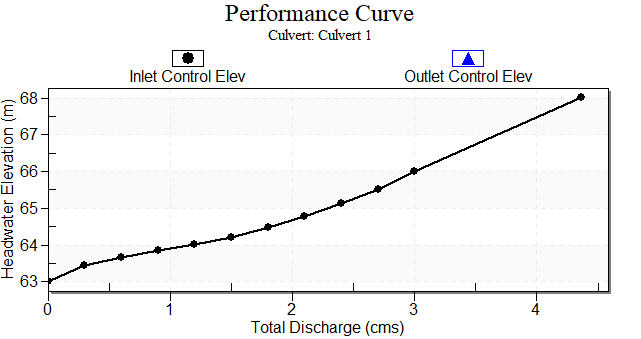

# Compare

You need to update the path to each file in the code block below. Run it and it will plot the results.


... SWMM Version 5.3.0.dev0
... Run Complete1


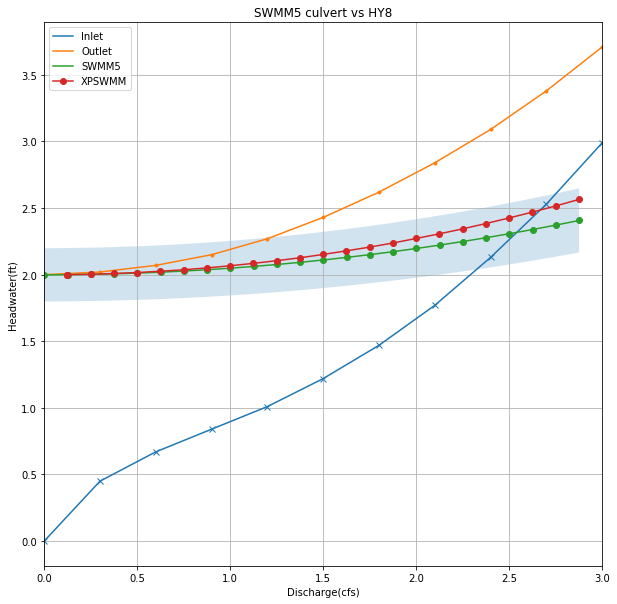

In [3]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\inverted"
swmm5_inp = os.path.join(ws, 'inverted.inp')
run(swmm5_inp)
swmm5_out = os.path.join(ws, 'inverted.out')
hy8_curve_csv = os.path.join(ws, 'inverted_performance_curve.csv')
xpswmm_csv = os.path.join(ws, 'xpswmm.csv')

compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv)

The comparison is shown above,
- X is the discharge, Y is the head water depth
- the green line is swmm5 results
- the shaded area is the 90-110% for the swmm5 simulated curve
- the orange is the inlet curve
- the blue is the outlet curve
- the red curve is XPSWMM result

The conclusions,
- the culvert performance curve is the higher of the inlet/outlet curve
- for the design flow 200cfs, both XPSMWW and SWMM shows very similar results within 10% to HY8
- SWMM5 showed stability issues for areas > 250 cfs
- XPSWMM doesn't follow the outlet control for areas < 50 cfs


For design purposes, the results look pretty good for the region around 200 cfs. 

The method showed above can be used as one quick way to verify a modeled culvert.


In [5]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\inverted"
swmm5_inp = os.path.join(ws, 'inverted.inp')
run(swmm5_inp)
swmm5_out = os.path.join(ws, 'inverted.out')
hy8_curve_csv = os.path.join(ws, 'inverted_performance_curve.csv')
xpswmm_csv = os.path.join(ws, 'xpswmm2.csv')

compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv)


... SWMM Version 5.3.0.dev0
... Run Complete1


FileNotFoundError: [Errno 2] File b'C:\\Users\\Mel.Meng\\Documents\\GitHub\\SewerAnalysis\\examples\\culvert\\data\\inverted\\xpswmm2.csv' does not exist: b'C:\\Users\\Mel.Meng\\Documents\\GitHub\\SewerAnalysis\\examples\\culvert\\data\\inverted\\xpswmm2.csv'